<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/04_EDA_Curate_Merge_Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04_EDA: Curate, Merge and Visualize Datasets (< 4 minutes)

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMconsortium/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.

**Warning: This is an experimental notebook**


## Goals

We will use the predownloaded ChEMBL datasets to carry out some of the following basic EDA using AMPL:  
* Loading the data
* Cleaning
* Merge datasets
* Visualization 
* Carry out some basic analysis

## Install AMPL

In [ ]:
import requests
import sys

# Copy AMPL install script
url='https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU.sh'

downloaded_obj = requests.get(url)
with open("install_AMPL_GPU.sh", "wb") as file:
    file.write(downloaded_obj.content)


# Install AMPL
!chmod u+x install_AMPL_GPU.sh
!time ./install_AMPL_GPU.sh

if '/content/AMPL/lib/python3.6/site-packages' not in sys.path:
    sys.path.insert(1, '/content/AMPL/lib/python3.6/site-packages')

## Let us download the datasets from Github 

In [3]:
## Roll this into a  function
import os
import requests
working_dir="/content"
# list_files = ['pgp_chembl.csv','bcrp_chembl.csv']
dataset_file = os.path.join(working_dir, 'pgp_chembl.csv')
if (not os.path.isfile(dataset_file)):
    r = requests.get('https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/pgp_chembl.csv', verify=True)
    with open(dataset_file, 'wb') as f:
        f.write(r.content)

dataset_file = os.path.join(working_dir, 'bcrp_chembl.csv')
if (not os.path.isfile(dataset_file)):
    r = requests.get('https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/bcrp_chembl.csv', verify=True)
    with open(dataset_file, 'wb') as f:
        f.write(r.content)

In [ ]:
%%bash
head bcrp*csv
echo ' '
head pgp*csv

,chembl,smile,pAct,relationship
0,BOERAVINONE G_CHEMBL221371,COc1cc(O)c2c(=O)c3c(oc2c1)C(OC)Oc1c(O)cccc1-3,6.16,=
1,BOERAVINONE H_CHEMBL222265,COc1cc2oc3c(c(=O)c2c(O)c1C)-c1cccc(O)c1OC3OC,5.6,=
2,None_CHEMBL243813,COc1cccc2[nH]c3ccccc3c(=O)c12,5.2,=
3,None_CHEMBL243169,COc1ccc2c(=O)c3cccc(C(=O)NCCc4ccc(OC)c(OC)c4)c3[nH]c2c1,5.86,=
4,None_CHEMBL243168,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccc(OC)cc4[nH]c23)cc1,6.25,=
5,None_CHEMBL243167,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccccc4[nH]c23)cc1OC,6.35,=
6,None_CHEMBL397235,COc1ccc(CCNC(=O)c2cccc3c(=O)c4ccccc4[nH]c23)cc1,6.46,=
7,None_CHEMBL242513,COc1cc(C(F)(F)F)cc2[nH]c3ccccc3c(=O)c12,6.11,=
8,None_CHEMBL243814,COc1cc(OC)c2c(=O)c3ccccc3[nH]c2c1,5.1,=
 
,chembl,smile,pAct,relationship
0,None_CHEMBL354935,COc1cc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)cccc43)c2)cc(OC)c1O,5.89,=
1,None_CHEMBL434871,COc1ccc(NC(=O)Cc2cccc(-n3c(=O)c4c(C)onc4c4c(Cl)cccc43)c2)cc1OC,5.39,=
2,None_CHEMBL354544,Cc1onc2c1c(=O)n(-c1cccc(CC(=O)Nc3ccc4c(c3)OCO4)c1)c1cccc(Cl)c21,5.4,=
3,

In [ ]:
# Load AMPL in this notebook

site_packages_path = '/content/AMPL/lib/python3.7/site-packages'
if site_packages_path not in sys.path:
  sys.path.insert(1, site_packages_path)
sys.path

['',
 '/content/AMPL/lib/python3.7/site-packages',
 '/content/AMPL/lib/python3.6/site-packages',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']



Here we will load 2 datasets, curate the rows, and visualize some basic tenets of the data. **Your starting dataset should have columns including:**
- unique compound identifier
- smiles strings (see https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi for a good lookup service)
    - **IMPORTANT: for optimal harmonizaton, first translate all SMILES to pubchem SMILES using the linked service**
    - either look up pubchem CIDs for compounds or do SMILES -> SMILES
    - this greatly improves RDKit base_smiles_from_smiles reduction
- an assay measurement value, ie pIC50
- labels like "active" or "inactive" or another label you want, such as the source of the data.

# Load packages, define functions

In [ ]:
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import atomsci.ddm.utils.struct_utils as struct_utils
import atomsci.ddm.utils.curate_data as curate_data

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

# Curating and merging datasets
Some of these merging steps will be highly dependent on the information contained in each individual dataset and what you want to keep after curation.

### **Step 0:** Read dataset
Read in dataset to be curated and merged. 

### Step 1: Initial curation for nan's and outliers
Drop NA values for assay measurement column. Here you should also examine empty quotes, unexpected zeros, or other values that might not be real.

### **Step 2:** Canonicalize smiles strings
Canonicalize smiles strings so they are comparable across datasets with `struct_utils.base_smiles_from_smiles`. Even though the next function performs this step, we need to do this here in order to maintain correct metadata indices.

In [7]:
dfp = pd.read_csv("pgp_chembl.csv", index_col=0)
dfp['rdkit_smile'] = dfp['smile'].apply(curate_data.base_smiles_from_smiles)
#remove chemicals without smile strings
dfp.drop(dfp[dfp.smile == ""].index, inplace=True)

In [9]:
dfp.describe()

,pAct
count,2449.000000
mean,5.835321
std,1.128584
min,4.000000
25%,5.080000
50%,5.700000
75%,6.400000
max,10.990000


In [ ]:
# look at length of dataset and duplicates.
print('Name duplecates:', dfp['chembl'].duplicated().sum())
print('SMILES duplecates:', dfp.rdkit_smile.duplicated().sum())
print('Shape:',dfp.shape)

Name duplecates: 786
SMILES duplecates: 789
Shape: (2449, 6)


### **Step 3:** Preserve and aggregate metadata
Split off metadata from parent dataframe and aggregate labels.

In [ ]:
dfp.columns

Index(['Unnamed: 0', 'chembl', 'smile', 'pAct', 'relationship', 'rdkit_smile'], dtype='object')

### **Step 4:** Aggregate assay data
Use the `aggregate_assay_data()` function to aggregate duplicate assay measurements, deal with censored values, and standardize measurement dataframe for modeling later. This method also re-does the canonical smiles strings. *Even if you know you have no duplicates, still perform this step to standardize the dataframe.* 

### **Step 5:** Merge metadata back in
Merge metadata with aggregated assay data.

In [ ]:
# 60uM threshold -> pIC50
import numpy as np
thresh=-np.log10(60/1000000)
thresh

4.221848749616356

In [ ]:
#average duplicated data
dfp_cur = curate_data.aggregate_assay_data(dfp, 
                         value_col='pAct', 
                         output_value_col='pAct_pgp',
                         label_actives=True, 
                         active_thresh=thresh,
                         id_col='chembl', 
                         smiles_col='rdkit_smile', 
                         relation_col='relationship', 
                         date_col=None)
print('actives:', dfp_cur.active.sum())

2 entries in input table are missing SMILES strings
1659 unique SMILES strings are reduced to 1659 unique base SMILES strings
actives: 1606


In [ ]:
dfp_cur

,compound_id,base_rdkit_smiles,relation,pAct_pgp,active
0,None_CHEMBL2372475,CC/C=C/C[C@@H](C)C[C@H]1C(=O)N[C@@H](C(C)C)C(=...,,5.570,1
1,None_CHEMBL2449493,CCC(=O)c1ccc(OC[C@H](O)CN2CCN(c3ccccc3C)CC2)cc1,,6.060,1
2,None_CHEMBL358299,OC(COc1ccccc1C(O)CCc1ccccc1)CN1CCCCC1,,6.045,1
3,None_CHEMBL2449384,O=C(CCc1ccccc1)c1cc(OCc2ccccc2)ccc1OC[C@H](O)C...,,6.940,1
4,None_CHEMBL1608805,CCOC(=O)c1cccc(NC(=O)c2cnc3ccccc3n2)c1,,4.510,1
...,...,...,...,...,...
1654,None_CHEMBL3355362,COc1cccc(CCNCCCCc2cn(-c3ccc(F)cc3)c3ccccc23)c1,,5.140,1
1655,None_CHEMBL131005,Cc1ccccc1N1CCN(CC(O)Cn2c(C)c(C(=O)CCc3ccccc3)c...,,6.680,1
1656,None_CHEMBL2449339,CC(=O)c1ccccc1OC[C@H](O)CN1CCCCC1,,4.500,1
1657,None_CHEMBL1900518,COc1cccc(-c2cc3nc(C)c(C)c(N4CCN(C(=O)c5ccoc5)C...,,10.890,1


In [ ]:
# previously this was 96!
print("Total uncensored values:", len(dfp_cur[dfp_cur.relation != '']))

Total uncensored values: 0


In [ ]:
dfp_cur.columns

Index(['compound_id', 'base_rdkit_smiles', 'relation', 'pAct_pgp', 'active'], dtype='object')

In [ ]:
print("Shape of curated dataframe:", dfp_cur.shape)

Shape of curated dataframe: (1659, 5)


### Step 5.5: Repeat
**Repeat** steps 1-5 for all dataframes you want to curate and merge.

In [ ]:
dfb = pd.read_csv("bcrp_chembl.csv", index_col=0)
dfb['rdkit_smile'] = dfb['smile'].apply(curate_data.base_smiles_from_smiles)
#remove chemicals without smile strings
dfb.drop(dfb[dfb.smile == ""].index, inplace=True)

In [ ]:
# look at length of dataset and duplicates.
print('name dupes:', dfb['chembl'].duplicated().sum())
print('smiles dupes:', dfb.rdkit_smile.duplicated().sum())
print('shape:',dfb.shape)

name dupes: 494
smiles dupes: 494
shape: (1251, 6)


In [ ]:
# BCRP
#run this for every pIC column
dfb_cur = curate_data.aggregate_assay_data(dfb, 
                         value_col='pAct', 
                         output_value_col='pAct_bcrp',
                         label_actives=True, 
                         active_thresh=thresh,
                         id_col='chembl', 
                         smiles_col='rdkit_smile', 
                         relation_col='relationship', 
                         date_col=None)
print('actives:', dfb_cur.active.sum())

0 entries in input table are missing SMILES strings
757 unique SMILES strings are reduced to 757 unique base SMILES strings
actives: 743


In [ ]:
# previously this was 215
print("Total uncensored values:", len(dfb_cur[dfb_cur.relation != '']))

Total uncensored values: 0


In [ ]:
# previously this was 571
print("Total uncensored values:", len(dfb_cur[(dfb_cur.relation != '')&(dfb_cur.relation != '')]))

Total uncensored values: 0


### Step 6: (optional)  Merge datasets for multitask modeling
Merge processed assay values together for each dataframe.

In [ ]:
print(dfp_cur.shape)
print(dfb_cur.shape)

(1659, 5)
(757, 5)


In [ ]:
# shape should be 1 extra for control compound
merge1 = pd.merge(dfp_cur, dfb_cur, how="outer", on=("compound_id", "base_rdkit_smiles", "relation", "active"), suffixes = ("_pgp", "_bcrp"))
print("Shape of merge1 dataframe:", merge1.shape)

#show compounds which are only active against either P-GP or BCRP
merge1[merge1.duplicated(subset='compound_id', keep=False)].sort_values('base_rdkit_smiles')

Shape of merge1 dataframe: (2228, 6)


,compound_id,base_rdkit_smiles,relation,pAct_pgp,active,pAct_bcrp
1565,None_CHEMBL3764781,COc1cc(OC)c2c(=O)cc(N3CCN(Cc4ccc(F)c(F)c4)CC3)...,,4.230000,1,NaN
2072,None_CHEMBL3764781,COc1cc(OC)c2c(=O)cc(N3CCN(Cc4ccc(F)c(F)c4)CC3)...,,NaN,0,4.180
614,None_CHEMBL260599,COc1cc2c(cc1OC)CN(CC/C=C1\CCCc3c(OC)cccc31)CC2,,5.898571,1,NaN
1957,None_CHEMBL260599,COc1cc2c(cc1OC)CN(CC/C=C1\CCCc3c(OC)cccc31)CC2,,NaN,0,4.050
565,None_CHEMBL472818,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)Nc3ccccc3N)cc1...,,4.680000,1,NaN
1866,None_CHEMBL472818,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)Nc3ccccc3N)cc1...,,NaN,0,4.205
1970,None_CHEMBL258574,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,,NaN,0,4.190
626,None_CHEMBL258574,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3cc(OC)c(OC)c...,,5.180000,1,NaN
1735,None_CHEMBL261632,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3ccc(N)cc3)cc...,,NaN,0,4.010
59,None_CHEMBL261632,COc1cc2c(cc1OC)CN(CCc1ccc(NC(=O)c3ccc(N)cc3)cc...,,5.262500,1,NaN


In [ ]:
merge1.to_csv('txptr_merged.csv')

### **Step 7:** Recreate associated metadata / labels

In [ ]:
import seaborn as sns
sns.set_context('poster')

In [ ]:
df=pd.read_csv("txptr_merged.csv", index_col=0)

### **Step 8:** Filter for other outliers
### Filter large compounds
I wanted to examine and model small molecules from this dataset so I removed compounds with long SMILES strings. This can also be done with molecular weight or other features of the data.

In [ ]:
# calculate molecular weight
df["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in df["base_rdkit_smiles"]]
df.columns

Index(['compound_id', 'base_rdkit_smiles', 'relation', 'pAct_pgp', 'active',
       'pAct_bcrp', 'mol_wt'],
      dtype='object')

Text(0.5, 0.98, 'Distribution of molecular weights')

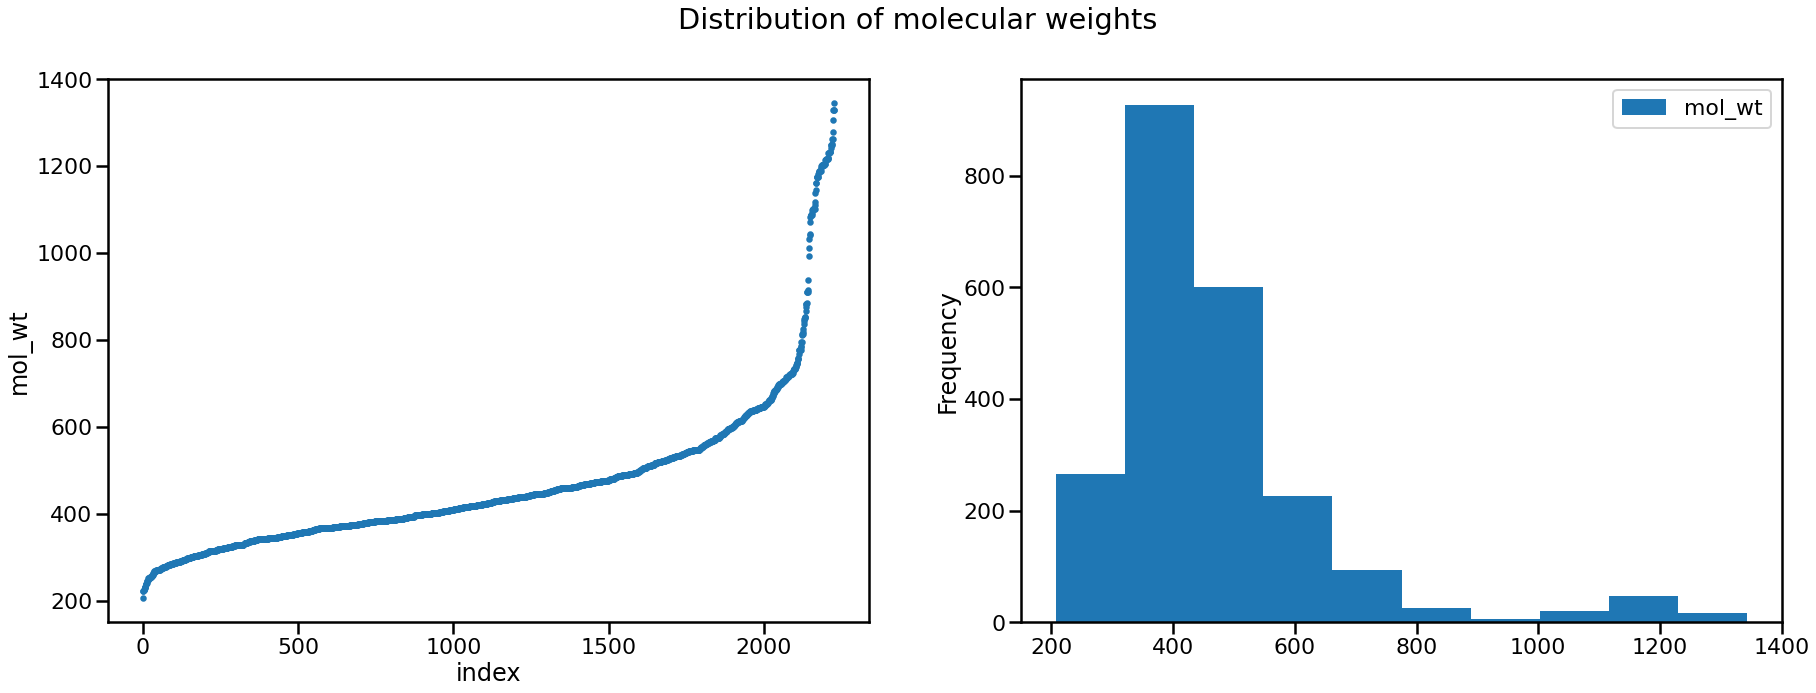

In [ ]:
# visualize distribution of molecular weights
df=df.sort_values(by='mol_wt')
df=df.reset_index(drop=True)
df=df.reset_index()

fig,ax=plt.subplots(1,2, figsize=(30,10))
df.plot(kind='scatter', x='index', y='mol_wt', ax=ax[0])
df.plot(kind='hist', x="index", y="mol_wt", ax=ax[1])
fig.suptitle("Distribution of molecular weights")

In [ ]:
print("Length of dataset:", df.shape[0])

print("\nMissing compound_id entries:", df['compound_id'].isna().sum())
print("Duplicate chembl_ids:", df['compound_id'].duplicated().sum())

print("\nMissing SMILES:", df['base_rdkit_smiles'].isna().sum())
print("Duplicate SMILES:", df['base_rdkit_smiles'].duplicated().sum())

print("\nMissing values should only be transporter-specific now because not all compounds have all measurements:")
print("Other missing values:", df.columns[df.isna().any()].tolist())
print("Missing P-GP values:", df['pAct_pgp'].isna().sum())
print("Missing BCRP values:", df['pAct_bcrp'].isna().sum())

Length of dataset: 2228

Missing compound_id entries: 0
Duplicate chembl_ids: 10

Missing SMILES: 0
Duplicate SMILES: 11

Missing values should only be transporter-specific now because not all compounds have all measurements:
Other missing values: ['relation', 'pAct_pgp', 'pAct_bcrp']
Missing P-GP values: 569
Missing BCRP values: 1471


### Step 9: Save dataframes

In [ ]:
!pwd

/content


In [ ]:
dfp_cur.to_csv("pgp_curated.csv")
dfb_cur.to_csv("bcrp_curated.csv")

In [ ]:
df.columns

Index(['index', 'compound_id', 'base_rdkit_smiles', 'relation', 'pAct_pgp',
       'active', 'pAct_bcrp', 'mol_wt'],
      dtype='object')

In [ ]:
df

,index,compound_id,base_rdkit_smiles,relation,pAct_pgp,active,pAct_bcrp,mol_wt
0,0,None_CHEMBL1215507,O=[N+]([O-])c1c(-c2ccccc2)no[n+]1[O-],NaN,4.28,1,NaN,207.028006
1,1,FLAVONE_CHEMBL275638,O=c1cc(-c2ccccc2)oc2ccccc12,NaN,4.47,1,4.675,222.068080
2,2,None_CHEMBL4091769,Cc1cc(C)c2[nH]c3ccccc3c(=O)c2c1,NaN,7.57,1,NaN,223.099714
3,3,None_CHEMBL573373,CSc1nc(N)c2c(C)c(C)sc2n1,NaN,5.88,1,NaN,225.039439
4,4,None_CHEMBL388886,COc1ccc2[nH]c3ccccc3c(=O)c2c1,NaN,NaN,1,5.320,225.078979
...,...,...,...,...,...,...,...,...
2223,2223,None_CHEMBL2372501,CC/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](C...,NaN,5.82,1,NaN,1305.903968
2224,2224,None_CHEMBL4104354,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCc2cn(CCOCCOCCOCC...,NaN,5.86,1,NaN,1328.338886
2225,2225,None_CHEMBL4071511,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCc2cn(CCOCCOCCOCC...,NaN,5.54,1,NaN,1328.338886
2226,2226,None_CHEMBL4092304,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCc2cn(CCOCCOCCOCC...,NaN,5.89,1,NaN,1328.338886


In [ ]:
df.to_csv("transporters_merged.csv")

In [ ]:
data = [dfp_cur["base_rdkit_smiles"], dfb_cur["base_rdkit_smiles"]]
headers = ["pgp", "bcrp"]
smiles_csv = pd.concat(data, axis=1, keys=headers)
smiles_csv.to_csv("transporters_rdkitsmiles.csv")

# Visualize data
- Compound overlaps
- pIC50 overlaps
- non-censored pIC50 value distributions
#### *Here outlier pIC50 values can also be filtered before continuing to model!*

In [ ]:
import matplotlib_venn as mpv

from scipy.stats import pearsonr

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

## Compound overlaps

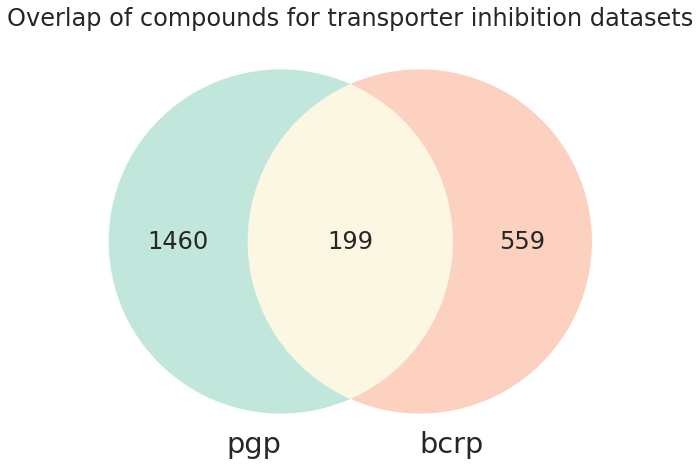

In [ ]:
mpv.venn2_unweighted([set(smiles_csv["pgp"]), set(smiles_csv["bcrp"])], set_labels = ("pgp", "bcrp"), set_colors = (pal[0], pal[1]))
plt.title('Overlap of compounds for transporter inhibition datasets');

# Conclusions
- there's a subset of values from tcpl vs kevin's code that are very different
- this is much better now that I ID'd my mistake in tcpl processing code

In [ ]:
df.columns

Index(['index', 'compound_id', 'base_rdkit_smiles', 'relation', 'pAct_pgp',
       'active', 'pAct_bcrp', 'mol_wt'],
      dtype='object')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


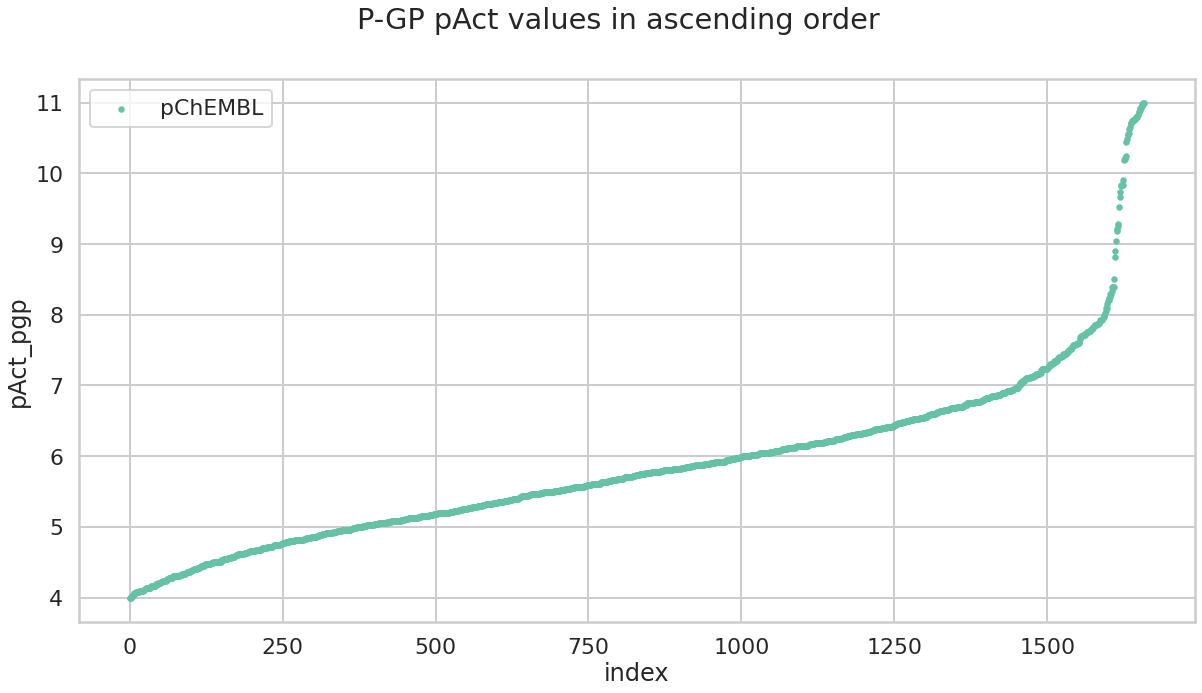

In [ ]:
plotdf=df
plotdf=plotdf.drop(columns="index")
plotdf=plotdf.sort_values('pAct_pgp')
plotdf=plotdf.reset_index(drop=True)
plotdf=plotdf.reset_index()

fig,ax=plt.subplots(figsize=(20, 10))
plotdf.plot(kind='scatter', x='index', y='pAct_pgp', label = 'pChEMBL', ax=ax)
fig.suptitle("P-GP pAct values in ascending order")
ax.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


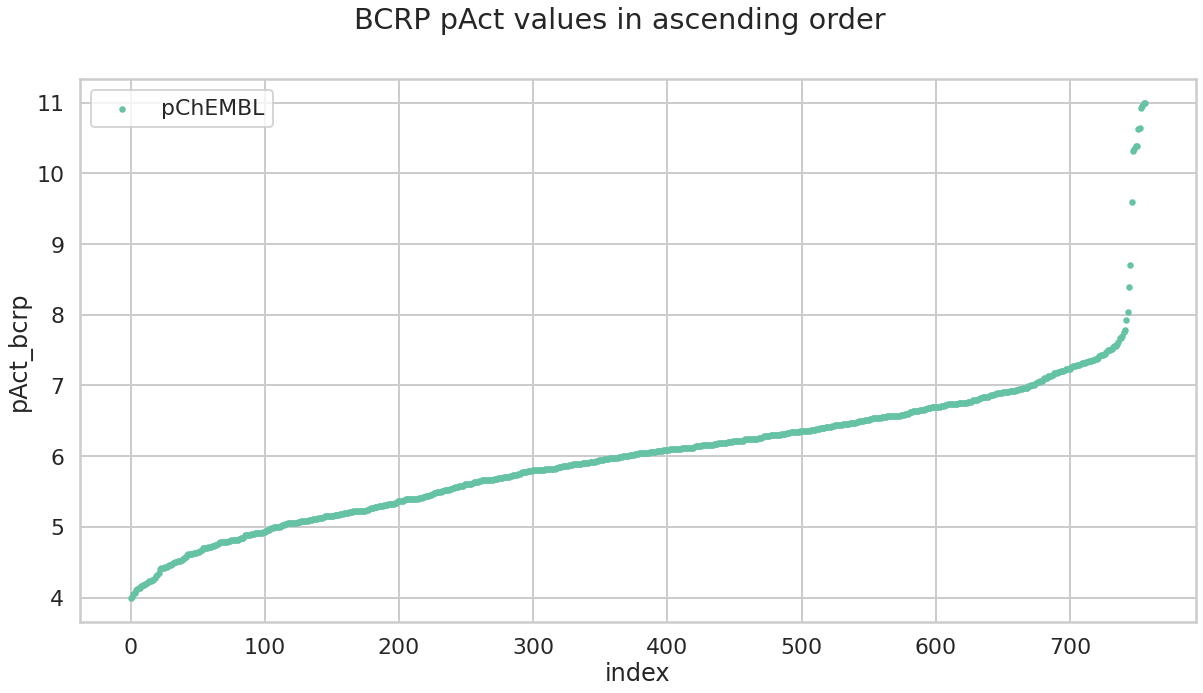

In [ ]:
plotdf=df
plotdf=plotdf.drop(columns="index")
plotdf=plotdf.sort_values('pAct_bcrp')
plotdf=plotdf.reset_index(drop=True)
plotdf=plotdf.reset_index()

fig,ax=plt.subplots(figsize=(20, 10))
plotdf.plot(kind='scatter', x='index', y='pAct_bcrp', label = 'pChEMBL', ax=ax)
fig.suptitle("BCRP pAct values in ascending order")
ax.legend();

## Optional steps:

If you want to save the files, then mount your Google Drive and copy it to a directory of your choice

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#copy files back to google drive to use them for other notebooks.
# %%bash

# cp /content/bcrp_curated.csv /content/drive/My\ Drive/
# cp /content/pgp_curated.csv /content/drive/My\ Drive/
# cp /content/transporters_merged.csv /content/drive/My\ Drive/
# cp /content/transporters_rdkitsmiles.csv /content/drive/My\ Drive/
# cp /content/txptr_merged.csv /content/drive/My\ Drive/
# cp /content/pgp_chembl.csv /content/drive/My\ Drive/
# cp /content/bcrp_chembl.csv /content/drive/My\ Drive/